# Project 2: Topic Classification

In this project, you'll work with text data from newsgroup postings on a variety of topics. You'll train classifiers to distinguish between the topics based on the text of the posts. Whereas with digit classification, the input is relatively dense: a 28x28 matrix of pixels, many of which are non-zero, here we'll represent each document with a "bag-of-words" model. As you'll see, this makes the feature representation quite sparse -- only a few words of the total vocabulary are active in any given document. The bag-of-words assumption here is that the label depends only on the words; their order is not important.

The SK-learn documentation on feature extraction will prove useful:
http://scikit-learn.org/stable/modules/feature_extraction.html

Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but please prepare your own write-up and write your own code.

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import matplotlib.pyplot as plt

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

Load the data, stripping out metadata so that we learn classifiers that only use textual features. By default, newsgroups data is split into train and test sets. We further split the test so we have a dev set. Note that we specify 4 categories to use for this project. If you remove the categories argument from the fetch function, you'll get all 20 categories.

In [252]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
newsgroups_train = fetch_20newsgroups(subset='train',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)
newsgroups_test = fetch_20newsgroups(subset='test',
                                     remove=('headers', 'footers', 'quotes'),
                                     categories=categories)

num_test = len(newsgroups_test.target)
splitAt = int(num_test/2)
test_data, test_labels = newsgroups_test.data[splitAt:], newsgroups_test.target[splitAt:]
dev_data, dev_labels = newsgroups_test.data[:splitAt], newsgroups_test.target[:splitAt]
train_data, train_labels = newsgroups_train.data, newsgroups_train.target

print('training label shape:', train_labels.shape)
print('test label shape:', test_labels.shape)
print('dev label shape:', dev_labels.shape)
print('labels names:', newsgroups_train.target_names)

training label shape: (2034,)
test label shape: (677,)
dev label shape: (676,)
labels names: ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']


### Question 1

For each of the first 5 training examples, print the text of the message along with the label.

[2 pts]

In [10]:
def P1(num_examples=5):
### STUDENT START ###
    labels = newsgroups_train.target_names
    for i in range(num_examples):
        print('===========================================================================')
        print('Message',i+1)
        print('Message Label:',labels[train_labels[i]])
        print(train_data[i])
        

### STUDENT END ###
P1(2)

Message 1
Message Label: comp.graphics
Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule information, does anyone have 
the format for the .PRJ file?

Is the .CEL file format available from somewhere?

Rych
Message 2
Message Label: talk.religion.misc


Seems to be, barring evidence to the contrary, that Koresh was simply
another deranged fanatic who thought it neccessary to take a whole bunch of
folks with him, children and all, to satisfy his delusional mania. Jim
Jones, circa 1993.


Nope - fruitcakes like Koresh have been demonstrating such evil corr

### Question 2
Use CountVectorizer to turn the raw training text into feature vectors. You should use the fit_transform function, which makes 2 passes through the data: first it computes the vocabulary ("fit"), second it converts the raw text into feature vectors using the vocabulary ("transform").

The vectorizer has a lot of options. To get familiar with some of them, write code to answer these questions:

The output of the transform (also of fit_transform) is a sparse matrix: http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.csr_matrix.html. 




e. Use the "min_df" argument to prune words that appear in fewer than 10 documents. What size vocabulary does this yield?

f. Using the standard CountVectorizer, what fraction of the words in the dev data are missing from the vocabulary? Hint: build a vocabulary for both train and dev and look at the size of the difference.

[6 pts]

(a)What is the size of the vocabulary?
   What is the average number of non-zero features per example?
   What fraction of the entries in the matrix are non-zero?

In [16]:
# initialize CountVectorizer
vector = CountVectorizer()
# transform train_data
tf = vector.fit_transform(train_data)
print('(a) responses:')
print('---------------------------------------')
print('non-zero features',tf.nnz)
print('size of the vocabulary',tf.shape[1])
print('average number of non-zero features per example',round(tf.nnz/tf.shape[0],1))
print('fraction of the entries in the matrix are non-zero is',
      round(tf.nnz/tf.shape[0]/tf.shape[1],4))

(a) responses:
---------------------------------------
non-zero features 196700
size of the vocabulary 26879
average number of non-zero features per example 96.7
fraction of the entries in the matrix are non-zero is 0.0036


(b) What are the 0th and last feature strings (in alphabetical order)? Hint: use the vectorizer's get_feature_names function.

In [17]:
# get feature names
print('(b) responses:')
print('---------------------------------------')
fea_names = vector.get_feature_names()
print('first feature name is',fea_names[0])
print('last feature name is', fea_names[-1])

(b) responses:
---------------------------------------
first feature name is 00
last feature name is zyxel


(c) Specify your own vocabulary with 4 words: ["atheism", "graphics", "space", "religion"]. Confirm the training vectors are appropriately shaped. Now what's the average number of non-zero features per example?

In [18]:
vocab = ['atheism','graphics','space','religion']
newVector = CountVectorizer(vocabulary=vocab)
newtf = newVector.fit_transform(train_data)
print('(c) responses:')
print('---------------------------------------')
print('New average number of non-zero features per example',
     round(newtf.nnz/newtf.shape[0],1))

(c) responses:
---------------------------------------
New average number of non-zero features per example 0.3


(d) Instead of extracting unigram word features, use "analyzer" and "ngram_range" to extract bigram and trigram character features. What size vocabulary does this yield?

In [30]:
bigramVector = CountVectorizer(analyzer='word',ngram_range=(2,2))
bigramtf = bigramVector.fit_transform(train_data)
trigramVector = CountVectorizer(analyzer='word',ngram_range=(3,3))
trigramtf = trigramVector.fit_transform(train_data)
print('(d) responses:')
print('---------------------------------------')
print('sizes of the vocabulary with bigram and trigram character features \n',
      bigramtf.shape[1],'and',trigramtf.shape[1],'respectively')

(d) responses:
---------------------------------------
sizes of the vocabulary with bigram and trigram character features 
 194891 and 315692 respectively


(e) Use the "min_df" argument to prune words that appear in fewer than 10 documents. What size vocabulary does this yield?

In [20]:
min_dfVector = CountVectorizer(min_df=10)
min_dftf = min_dfVector.fit_transform(train_data)

print('(e) responses:')
print('---------------------------------------')
print('size of the vocabulary with bigram and trigram character features',
      min_dftf.shape[1])

(e) responses:
---------------------------------------
size of the vocabulary with bigram and trigram character features 3064


(f) Using the standard CountVectorizer, what fraction of the words in the dev data are missing from the vocabulary? Hint: build a vocabulary for both train and dev and look at the size of the difference.

In [35]:
trainVocab= CountVectorizer().fit_transform(train_data)
devVocab = CountVectorizer().fit_transform(dev_data)

print('(f) responses:')
print('---------------------------------------')
print('fraction of words in the dev data missing from the vocabulary',
     (trainVocab.shape[1]-devVocab.shape[1])/trainVocab.shape[1])

(f) responses:
---------------------------------------
fraction of words in the dev data missing from the vocabulary 0.395587633468507


### Question 3
Use the default CountVectorizer options and report the f1 score (use metrics.f1_score) for a k nearest neighbors classifier; find the optimal value for k. Also fit a Multinomial Naive Bayes model and find the optimal value for alpha. Finally, fit a logistic regression model and find the optimal value for the regularization strength C using l2 regularization. 

[4 pts]

**NOTE**
Here I decided to tune the hyperparameters with only the training set
and gridsearchCV. It seems to be
the standard practice from what I've discovered from online materials. 

In [49]:
# Get train and dev matrices
trainVector = CountVectorizer()
trainMatrix = trainVector.fit_transform(train_data)
devMatrix = trainVector.transform(dev_data)

#knn

neighbors = {'n_neighbors':[i for i in range(1,100)]}
grid_knn = GridSearchCV(KNeighborsClassifier(),neighbors,scoring = 'f1_weighted')
grid_knn.fit(trainMatrix,train_labels)
#print(grid_knn.grid_scores_)
nBest = grid_knn.best_params_['n_neighbors']
print('best # of neighbors',nBest)
print('best f1 weighted score for 1-100 neighbros',grid_knn.best_score_)

best # of neighbors {'n_neighbors': 96}



In [54]:
# multinomial Naives Bayes
alphas = {'alpha':[0.00001,0.0001,0.001,0.01,0.1,0.25,0.5,1,2.5,5,10,25]}
grid_mnb = GridSearchCV(MultinomialNB(),alphas,scoring='f1_weighted')
grid_mnb.fit(trainMatrix,train_labels)
print('best alpha ',grid_mnb.best_params_,'\n and f1 score',grid_mnb.best_score_)

best alpha  {'alpha': 0.01} 
 and f1 score 0.828718198342


In [56]:
# Logistic Regression
Cs = {'C':np.linspace(0.01,10,50)}
grid_logit = GridSearchCV(LogisticRegression(),Cs) #default l2 regularization
grid_logit.fit(trainMatrix,train_labels)
print('best C ',grid_logit.best_params_,'\n and f1 score',grid_logit.best_score_)

best C  {'C': 0.21387755102040817} 
 and f1 score 0.77581120944


ANSWER:

**a. Why doesn't nearest neighbors work well for this problem?**
The number of features, or the size of the vocabulary, is quite large for
nearest neighbors to compute the distance between messages.

**b. Any ideas why logistic regression doesn't work as well as Naive Bayes?**
Logistic regression is a linear model which depends on several assumption to work. 
One of which is no multicolinearity, which might be a problem with this dataset.

** c. Logistic regression estimates a weight vector for each class, which you can access with the coef\_ attribute. Output the sum of the squared weight values for each class for each setting of the C parameter. Briefly explain the relationship between the sum and the value of C.

see BELOW


In [81]:
#Specify some Cs
Cs = [0.01,0.1,0.2,0.214,0.3,0.5,1,2]
c = [[],[],[],[]]

# initialize sum of squared weights for each class
ssq = dict(zip(newsgroups_train.target_names,c))
for c in Cs:
    lr = LogisticRegression(C = c)
    lr.fit(trainMatrix,train_labels)
    for i in range(4):
        ssq[newsgroups_train.target_names[i]].append(sum(np.square(lr.coef_[i])))

#import Pandas for DataFrame
import pandas as pd
# Output sume of the square weight values
weight_df = pd.DataFrame(ssq)
weight_df['C'] = Cs
weight_df

,alt.atheism,comp.graphics,sci.space,talk.religion.misc,C
0,2.541396,2.939709,2.862469,2.250029,0.010
1,27.134654,24.658763,27.458395,23.020923,0.100
2,49.737854,42.743152,49.328589,42.668929,0.200
3,52.633976,45.000943,52.102035,45.186473,0.214
4,69.287066,57.875521,67.903946,59.754476,0.300
5,102.585981,83.120425,99.030250,88.989113,0.500
6,166.997666,130.924245,158.021311,145.715357,1.000
7,257.670955,197.979419,239.935842,226.667603,2.000


As C increases, the sum squared weight also increases but at a much faster rate.
Since C is the inverse of regularization strength, the higher C corresponds to lower penalty
and hence larger weights.

### Quesion 4
Train a logistic regression model. Find the 5 features with the largest weights for each label -- 20 features in total. Create a table with 20 rows and 4 columns that shows the weight for each of these features for each of the labels. Create the table again with bigram features. Any surprising features in this table?

[5 pts]

In [159]:
# From Q3, select C to be the optimal values
lr = LogisticRegression(C = 0.214)
lr.fit(trainMatrix,train_labels)
coeff = lr.coef_.copy()
coeff_index = coeff.copy()
for i in range(4):
    # get sorted index
    coeff_index[i] = np.argsort(coeff_index[i])[::-1]

top20_features = []
top20_features_index = []
feature_names = trainVector.get_feature_names()
for i, label in enumerate(newsgroups_train.target_names):
    print('top 5 features for',label)
    feature_index = [int(k) for k in coeff_index[i][:5]]
    top_features = [feature_names[j] for j in feature_index]
    print(top_features)
    top20_features.append(top_features)
    top20_features_index.append(feature_index)

top20_features = sum(top20_features,[])
top20_features_index = sum(top20_features_index,[])


top 5 features for alt.atheism
['bobby', 'religion', 'atheism', 'atheists', 'islam']
top 5 features for comp.graphics
['graphics', 'image', 'file', '3d', 'computer']
top 5 features for sci.space
['space', 'orbit', 'nasa', 'launch', 'spacecraft']
top 5 features for talk.religion.misc
['christian', 'christians', 'blood', 'fbi', 'order']


In [160]:
top20_df = pd.DataFrame(index = top20_features)
for i, label in enumerate(newsgroups_train.target_names):
    top20_df[label] = coeff[i][top20_features_index]
top20_df


In [161]:
top20_df

,alt.atheism,comp.graphics,sci.space,talk.religion.misc
bobby,0.633928,-0.153922,-0.221420,-0.299686
religion,0.627966,-0.389941,-0.511133,-0.022134
atheism,0.627935,-0.273714,-0.273447,-0.316958
atheists,0.621280,-0.087596,-0.207094,-0.434640
islam,0.538657,-0.094619,-0.218037,-0.220039
graphics,-0.512665,1.280929,-0.847929,-0.481674
image,-0.350446,0.853304,-0.500494,-0.286956
file,-0.217866,0.825938,-0.539695,-0.381561
3d,-0.237167,0.726801,-0.425194,-0.243522
computer,-0.000118,0.691126,-0.437128,-0.300637


In [168]:
# find best C for bigram
bigramVector = CountVectorizer(analyzer='word',ngram_range=(2,2))
biTrainMatrix = bigramVector.fit_transform(train_data)

Cs = {'C':np.linspace(0.01,4,50)}
grid_logit = GridSearchCV(LogisticRegression(),Cs) #default l2 regularization
grid_logit.fit(biTrainMatrix,train_labels)
print('best C ',grid_logit.best_params_,'\n and f1 score',grid_logit.best_score_)

best C  {'C': 1.0685714285714287} 
 and f1 score 0.676007866273


In [169]:
# train bigram logistics using the best C

lr = LogisticRegression(C = 1.068)
lr.fit(biTrainMatrix,train_labels)
coeff = lr.coef_.copy()
coeff_index = coeff.copy()
for i in range(4):
    # get sorted index
    coeff_index[i] = np.argsort(coeff_index[i])[::-1]

top20_features = []
top20_features_index = []
feature_names = bigramVector.get_feature_names()
for i, label in enumerate(newsgroups_train.target_names):
    print('top 5 features for',label)
    feature_index = [int(k) for k in coeff_index[i][:5]]
    top_features = [feature_names[j] for j in feature_index]
    print(top_features)
    top20_features.append(top_features)
    top20_features_index.append(feature_index)

top20_features = sum(top20_features,[])
top20_features_index = sum(top20_features_index,[])

top 5 features for alt.atheism
['claim that', 'was just', 'cheers kent', 'look up', 'you are']
top 5 features for comp.graphics
['looking for', 'comp graphics', 'in advance', 'is there', 'out there']
top 5 features for sci.space
['the space', 'the moon', 'sci space', 'sherzer methodology', 'and such']
top 5 features for talk.religion.misc
['ignorance is', 'such lunacy', 'compuserve com', 'is strength', 'the fbi']


In [170]:
top20_bi_df = pd.DataFrame(index = top20_features)
for i, label in enumerate(newsgroups_train.target_names):
    top20_bi_df[label] = coeff[i][top20_features_index]
top20_bi_df

,alt.atheism,comp.graphics,sci.space,talk.religion.misc
claim that,0.787495,-0.263887,-0.360149,-0.207229
was just,0.697029,-0.199715,-0.205674,-0.310175
cheers kent,0.657213,-0.901589,-0.837792,0.607024
look up,0.655143,-0.246863,-0.202830,-0.178268
you are,0.578494,-0.322426,-0.586614,-0.002087
looking for,-0.768235,1.340036,-0.625289,-0.712906
comp graphics,-0.389278,1.060423,-0.481485,-0.409001
in advance,-0.553536,0.985625,-0.540293,-0.516314
is there,-0.437407,0.927539,-0.578904,-0.350251
out there,-0.329225,0.909609,-0.587626,-0.338477


ANSWER:
The optimal value for C was found for bigram data. "the fbi" shows up in talk.religion. Besides "comp graphics", other bigrams for comp.graphics aren't computer related as in the previous part. Someone named "kent" was probably a major contributor to alt.atheism.

### Question 5
Try to improve the logistic regression classifier by passing a custom preprocessor to CountVectorizer. The preprocessing function runs on the raw text, before it is split into words by the tokenizer. Your preprocessor should try to normalize the input in various ways to improve generalization. For example, try lowercasing everything, replacing sequences of numbers with a single token, removing various other non-letter characters, and shortening long words. If you're not already familiar with regular expressions for manipulating strings, see https://docs.python.org/2/library/re.html, and re.sub() in particular. With your new preprocessor, how much did you reduce the size of the dictionary?

For reference, I was able to improve dev F1 by 2 points.

[4 pts]

In [301]:
def empty_preprocessor(s):
    return s

def better_preprocessor(s):
    #lower s
    s = s.lower()
    
    # remove endings like 'ed','s','ed'
    s = re.sub(r"ing\b|ed\b|s\b",r"",s)
    
    # remove special characters
    s = re.sub(r"[_%#:+]/?!#$%^&*(){}", r"", s)
    
    # substitute underscore with space
    s = re.sub(r"_"," ",s)

    newS = ''
    for word in s:
        #exclude words with both letters and numbers
        if any(c.isalpha() for c in word) and any(c.isdigit() for c in word):
            newS +=''
        else:
            newS += word
    return newS

def lrPreprocessor(preprocessorName):
    trainVector = CountVectorizer(preprocessor = preprocessorName)
    trainMatrix = trainVector.fit_transform(train_data)
    #Use test data here
    devMatrix = trainVector.transform(dev_data)
    vocabSize = trainMatrix.shape[1]
    
    lr = LogisticRegression(C=0.214).fit(trainMatrix,train_labels)
    prediction = lr.predict(devMatrix)
    return metrics.f1_score(dev_labels,prediction,average='weighted'),vocabSize

empty,emptysize = lrPreprocessor(empty_preprocessor)
better, bettersize = lrPreprocessor(better_preprocessor)

print('Improvement with preprocessing dev F1 value', round((better-empty)*100,3),'%')
print('Reduction in Vocabulary Size',round((emptysize-bettersize)\
                                           /emptysize*100,3),'%')
    

Improvement with preprocessing dev F1 value 1.929 %
Reduction in Vocabulary Size 33.18 %


### Question 6
The idea of regularization is to avoid learning very large weights (which are likely to fit the training data, but not generalize well) by adding a penalty to the total size of the learned weights. That is, logistic regression seeks the set of weights that minimizes errors in the training data AND has a small size. The default regularization, L2, computes this size as the sum of the squared weights (see P3, above). L1 regularization computes this size as the sum of the absolute values of the weights. The result is that whereas L2 regularization makes all the weights relatively small, L1 regularization drives lots of the weights to 0, effectively removing unimportant features.

Train a logistic regression model using a "l1" penalty. Output the number of learned weights that are not equal to zero. How does this compare to the number of non-zero weights you get with "l2"? Now, reduce the size of the vocabulary by keeping only those features that have at least one non-zero weight and retrain a model using "l2".

Make a plot showing accuracy of the re-trained model vs. the vocabulary size you get when pruning unused features by adjusting the C parameter.

Note: The gradient descent code that trains the logistic regression model sometimes has trouble converging with extreme settings of the C parameter. Relax the convergence criteria by setting tol=.01 (the default is .0001).

[4 pts]

In [217]:
np.random.seed(0)
# Get train and dev matrices
trainVector = CountVectorizer()
trainMatrix = trainVector.fit_transform(train_data)
devMatrix = trainVector.transform(dev_data)

#train l1 losgistic 
lr_l1 = LogisticRegression(penalty='l1',tol=0.01)
lr_l1.fit(trainMatrix,train_labels)
lr_l2 = LogisticRegression(penalty='l2',tol=0.01)
lr_l2.fit(trainMatrix,train_labels)

# get nonzero indices, np.nonzero return a tuple
nonzero_index1 = np.unique(np.nonzero(lr_l1.coef_)[1])
nonzero_index2 = np.unique(np.nonzero(lr_l2.coef_)[1])

# print count of non zero
print('Nonzero weights for L1 and L2',len(nonzero_index1),' and ',len(nonzero_index2))
print('Count for L1 is much smaller than L2')

print('model accuracy with L2 only',lr_l2.score(devMatrix,dev_labels))

# get new vocab, convert to nparray for easy indexing

nonZeroVocab = np.array(trainVector.get_feature_names())[nonzero_index1]

nonZeroVec = CountVectorizer(vocabulary=nonZeroVocab)
newMatrix = nonZeroVec.fit_transform(train_data)
newDevMatrix = nonZeroVec.transform(dev_data)
lr_l1_l2 = LogisticRegression(penalty='l2',tol=0.01).fit(newMatrix,train_labels)
print('Model accuracy after L1 then L2 with default C =1:',
      lr_l1_l2.score(newDevMatrix,dev_labels))


Nonzero weights for L1 and L2 1061  and  26879
Count for L1 is much smaller than L2
model accuracy with L2 only 0.715976331361
Model accuracy after L1 then L2 with default C =1: 0.680473372781


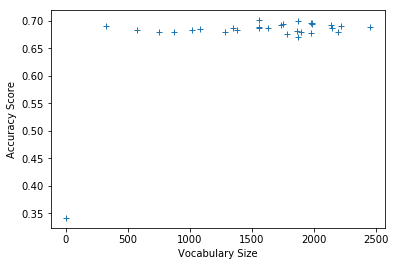

In [302]:
vocabSize = []
score = []
f1_score = []
Cs = np.linspace(0.001,5,30)

for c in Cs:
    
    #train l1 losgistic 
    lr_l1 = LogisticRegression(penalty='l1',tol=0.01, C = c)
    lr_l1.fit(trainMatrix,train_labels)

    # get nonzero indices, np.nonzero return a tuple
    nonzero_index = np.unique(np.nonzero(lr_l1.coef_)[1])
    vocabSize.append(len(nonzero_index))
    # get new vocab, convert to nparray for easy indexing
    nonZeroVocab = np.array(trainVector.get_feature_names())[nonzero_index]
    nonZeroVec = CountVectorizer(vocabulary=nonZeroVocab)
    newMatrix = nonZeroVec.fit_transform(train_data)
    newDevMatrix = nonZeroVec.transform(dev_data)
    
    #train new model
    lr_l1_l2 = LogisticRegression(penalty='l2',tol=0.01, C=c).fit(newMatrix,train_labels)
    score.append(lr_l1_l2.score(newDevMatrix,dev_labels))
    
    prediction = lr_l1_l2.predict(newDevMatrix)
    f1_score.append(metrics.f1_score(dev_labels,prediction,average='weighted'))
    
plt.plot(vocabSize,score,'+')
plt.xlabel('Vocabulary Size')
plt.ylabel('Accuracy Score')

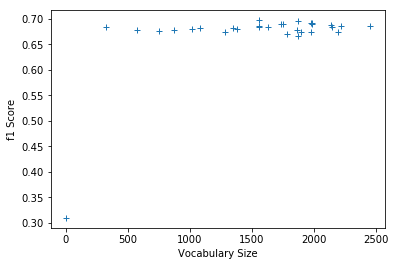

In [303]:
plt.plot(vocabSize,f1_score,'+')
plt.xlabel('Vocabulary Size')
plt.ylabel('f1 Score')

### Question 7

Use the TfidfVectorizer -- how is this different from the CountVectorizer? Train a logistic regression model with C=100.

Make predictions on the dev data and show the top 3 documents where the ratio R is largest, where R is:

maximum predicted probability / predicted probability of the correct label

What kinds of mistakes is the model making? Suggest a way to address one particular issue that you see.

[4 pts]

In [198]:
tVector = TfidfVectorizer()
tMatrix = tVector.fit_transform(train_data)
tDevMatrix = tVector.transform(dev_data)

names = newsgroups_train.target_names
# Get Predict probabilities
lr = LogisticRegression(C=100).fit(tMatrix,train_labels)
tPredProb  = lr.predict_proba(tDevMatrix)
tPred = lr.predict(tDevMatrix)

R_ratio = []
for index, probs in enumerate(tPredProb):
    max_prob = max(probs)
    correct_prob = probs[dev_labels[index]]
    R_ratio.append(max_prob/correct_prob)

R_ratio = np.array(R_ratio)
sortedR_index = np.argsort(R_ratio)[::-1]

for index in sortedR_index[:3]:
    print("++++++++++++++++++++++++++")
    print('R ratio is', R_ratio[index])
    print('Predict label:',names[tPred[index]])
    print('Correct label:',names[dev_labels[index]])
    print('Document \n',dev_data[index])


++++++++++++++++++++++++++
R ratio is 929.357878804
Predict label: comp.graphics
Correct label: talk.religion.misc
Document 
 I am pleased to announce that a *revised version* of _The Easy-to-Read Book
of Mormon_ (former title: _Mormon's Book_) by Lynn Matthews Anderson is now
available through anonymous ftp (see information below). In addition to the
change in title, the revised ETR BOM has been shortened by several pages
(eliminating many extraneous "that's" and "of's"), and many (minor) errors
have been corrected. This release includes a simplified Joseph Smith Story,
testimonies of the three and eight witnesses, and a "Words-to-Know"
glossary.

As with the previous announcement, readers are reminded that this is a
not-for-profit endeavor. This is a copyrighted work, but people are welcome
to make *verbatim* copies for personal use. People can recuperate the
actual costs of printing (paper, copy center charges), but may not charge
anything for their time in making copies, or in any 

ANSWER:

**Use the TfidfVectorizer -- how is this different from the CountVectorizer?**
tfidfVectorizer is equivalent to CountVectorizer followed by TfidfTransformer which times
 raw frequencies with the inverse document-frequency, reducing the impact of a term
 that occur frequently in a given corpus. (from sklearn documentation)
 
**What kinds of mistakes is the model making? 
Suggest a way to address one particular issue that you see.**

The model misclassified relatively longer or shorter documents and probably catches only
the keywords instead of the main point. Maybe normalize the term frequency with the document's length and gives more weight to certain word than others. For example, in the doc with the 2nd highest R-ratio, the topic is religion because of "book of mormon" but the text contai
contains many computer related keywords.




(8) EXTRA CREDIT

Try implementing one of your ideas based on your error analysis. Use logistic regression as your underlying model.

- [1 pt] for a reasonable attempt
- [2 pts] for improved performance